In [17]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from data import train_dataset, N, x, t
import torch.nn.functional as F

In [18]:
class MixtureDensityNet(nn.Module):
    '''
    Two Layer mixture density network with 3 classes.
    '''
    
    def __init__(self, n_components):
        super().__init__()
        self.components = n_components
        self.network = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5,5),
            nn.ReLU(),
            nn.Linear(5, self.components*3),
        )
      
    def forward(self, x, epsilon=1e-6):
        preact = self.network(x)
        pi = F.softmax(preact[...,:self.components], -1)
        mu = preact[...,self.components:self.components*2]
        sigma = torch.exp(preact[...,self.components*2:self.components*3] + epsilon)
        return pi, mu, sigma

    def mode(self, x):
        pi, mu, _ = self.forward(x)
        argpi = torch.argmax(pi)
        mu = torch.flatten(mu)
        return mu[argpi.item()]

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mixture_model = MixtureDensityNet(3).to(device)

#hyperparameters
learning_rate = 0.001
batch_size = 300
epochs = 5000

optimizer = torch.optim.Adam(mixture_model.parameters(), lr=learning_rate)
dataloader = DataLoader(train_dataset(x, t), batch_size = batch_size, shuffle = False)

In [20]:
class MixtureLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    @classmethod
    def gaussian(cls, t, mu, sigma):
        res = (t.expand_as(mu) - mu) * torch.reciprocal(sigma)
        res = -0.5 * (res * res)
        return torch.exp(res)*torch.reciprocal(sigma) * (1.0/ np.sqrt(2.0* np.pi))

    def forward(self, pred, target):
        pi, mu, sigma = pred
        result = MixtureLoss.gaussian(target, mu, sigma) * pi 
        result = torch.sum(result, dim = 1)
        result = -torch.log(result)
        return torch.mean(result)

loss_fn = MixtureLoss()

In [21]:
def train():
    mixture_model.train()

    for epoch in tqdm(range(epochs)):
        losstot = 0
        for batch, (x, t) in enumerate(dataloader):
            x, t = x.to(device), t.to(device)
            pred = mixture_model(t)
            loss = loss_fn(pred, x)
            
            with torch.no_grad():
                losstot += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        tqdm.write(f'epoch: {epoch}, loss: {losstot}')

In [22]:
train()

  0%|          | 0/5000 [00:00<?, ?it/s]

epoch: 0, loss: 1.0890438556671143
epoch: 1, loss: 1.0877364873886108
epoch: 2, loss: 1.0864276885986328
epoch: 3, loss: 1.0851181745529175
epoch: 4, loss: 1.0838078260421753
epoch: 5, loss: 1.082497477531433
epoch: 6, loss: 1.0811867713928223
epoch: 7, loss: 1.0798730850219727
epoch: 8, loss: 1.078552484512329
epoch: 9, loss: 1.07723069190979
epoch: 10, loss: 1.0759071111679077
epoch: 11, loss: 1.0745805501937866
epoch: 12, loss: 1.0732502937316895
epoch: 13, loss: 1.071919560432434
epoch: 14, loss: 1.0705870389938354
epoch: 15, loss: 1.069251298904419
epoch: 16, loss: 1.0679130554199219
epoch: 17, loss: 1.0665732622146606
epoch: 18, loss: 1.0652318000793457
epoch: 19, loss: 1.063887596130371
epoch: 20, loss: 1.0625382661819458
epoch: 21, loss: 1.061187982559204
epoch: 22, loss: 1.059830904006958
epoch: 23, loss: 1.0584604740142822
epoch: 24, loss: 1.0570753812789917
epoch: 25, loss: 1.05567467212677
epoch: 26, loss: 1.054255485534668
epoch: 27, loss: 1.052815556526184
epoch: 28, loss

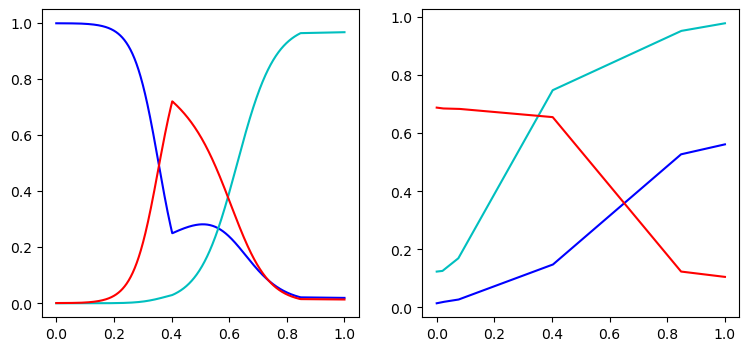

In [23]:
fig, (subplot1, subplot2) = plt.subplots(1,2, figsize=(9,4))
mixture_model.eval().cpu()
inputs = np.linspace(0,1, 1000)
with torch.no_grad():
    input_tensors = [torch.tensor(i, dtype=torch.float32).unsqueeze(0) for i in inputs]
    output_pis = [mixture_model(i)[0].flatten() for i in input_tensors]
    pi1 = [j[0].item() for j in output_pis]
    pi2 = [j[1].item() for j in output_pis]
    pi3 = [j[2].item() for j in output_pis]
    subplot1.plot(inputs, pi1, c = 'b')
    subplot1.plot(inputs, pi2, c = 'c')
    subplot1.plot(inputs, pi3, c = 'r')

    output_mus = [mixture_model(i)[1].flatten() for i in input_tensors]
    mu1 = [j[0].item() for j in output_mus]
    mu2 = [j[1].item() for j in output_mus]
    mu3 = [j[2].item() for j in output_mus]
    subplot2.plot(inputs, mu1, c = 'b')
    subplot2.plot(inputs, mu2, c = 'c')
    subplot2.plot(inputs, mu3, c = 'r')

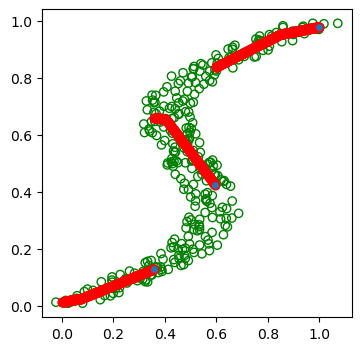

In [24]:
plt.figure(figsize=(4,4))
plt.scatter(t,x, edgecolors='g', facecolors='none')
inputs = np.linspace(0,1, 1000)
with torch.no_grad():
    input_tensors = [torch.tensor(i, dtype=torch.float32).unsqueeze(0) for i in inputs]
    outputs = [mixture_model.mode(i).item() for i in input_tensors]
    plt.scatter(inputs,outputs, edgecolors='r')
    plt.show()